In [20]:

from kevlib import common_import_script
%run $common_import_script
from astropy.coordinates import SkyCoord
from astroscrappy import detect_cosmics
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
import lmfit
from astropy.io import fits
from kevlib.utils.plot import plot_images
from glob import glob
import kevlib.image as kli
from kevlib.utils import fix_byte_order
import urllib.parse
from astropy.io import ascii as astro_ascii
from scipy.ndimage import binary_dilation, binary_erosion
import shapely
from shapely.geometry import Polygon, Point

def is_point_inside_bounding_area(bounding_points, point_to_check):
    # Create a Polygon from the bounding points
    polygon = Polygon(bounding_points)
    
    # Create a Point object from the point to check
    point = Point(point_to_check)
    
    # Check if the point is within the polygon
    return polygon.contains(point)

---------------------------------------------------------------------------------------
|                        Last run date: 2025-07-06 02:19 AM E                         |
---------------------------------------------------------------------------------------
| Python | Jupyterlab | Numpy  | Scipy  | Astropy | Matplotlib | Tensorflow | Pytorch |
---------------------------------------------------------------------------------------
| 3.11.4 |   4.4.3    | 1.24.3 | 1.11.1 |  5.3.1  |   3.8.3    |   2.13.1   |  2.0.1  |
---------------------------------------------------------------------------------------


In [21]:
import numpy as np

def find_patterns(image):
    target_value = 268435456

    height, width = image.shape
    mask_image = np.zeros((height, width), dtype=int)

    for y in range(height - 1):
        for x in range(width - 1):
            if (image[y, x] == target_value and
                image[y, x + 1] == target_value and
                image[y + 1, x] == target_value and
                image[y + 1, x + 1] == target_value):
                
                mask_image[y, x] = 1
                mask_image[y, x + 1] = 1
                mask_image[y + 1, x] = 1
                mask_image[y + 1, x + 1] = 1

            if (image[y, x] == target_value and
                image[y + 1, x + 1] == target_value):
                mask_image[y, x] = 1
                mask_image[y + 1, x + 1] = 1

            if (image[y, x + 1] == target_value and
                image[y + 1, x] == target_value):
                mask_image[y, x + 1] = 1
                mask_image[y + 1, x] = 1

            if image[y, x] == target_value and image[y + 1, x] == target_value:
                mask_image[y, x] = 1
                mask_image[y + 1, x] = 1

            if image[y, x] == target_value and image[y, x + 1] == target_value:
                mask_image[y, x] = 1
                mask_image[y, x + 1] = 1

    for y in range(height - 1):
        if image[y, width - 1] == target_value and image[y + 1, width - 1] == target_value:
            mask_image[y, width - 1] = 1
            mask_image[y + 1, width - 1] = 1

    for x in range(width - 1):
        if image[height - 1, x] == target_value and image[height - 1, x + 1] == target_value:
            mask_image[height - 1, x] = 1
            mask_image[height - 1, x + 1] = 1

    return mask_image


def remove_artifacts(mask, img):
    
    original_img = np.copy(img)
    
    bm = find_patterns(mask)
    c_obj_map = binary_dilation(bm, iterations=4)
    
    img[c_obj_map] = np.nan
    non_nan_pixels = img[~np.isnan(img)]
    background_noise = np.std(non_nan_pixels)
    
    nan_mask = np.isnan(img)
    
    img[nan_mask] = np.random.normal(0, background_noise, size=nan_mask.sum())
    
    # plot_images([mask, original_img, c_obj_map, img], fig_height=2, norm_same=False)
    if (original_img==img).all():
        corrected = False;
    else:
        corrected= True
    return img, corrected

In [ ]:
?mask

In [22]:
search_frames = []
mjds = []

query = "https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-query?catalog=neowiser_p1bm_frm&spatial=None&outfmt=1&constraints="
query += "(ra1 > 50 and ra1 < 55) and (dec1 > 19 and dec1 < 24) and (mjd_obs <= 59815 and mjd_obs > 59805) and band=2"

url = urllib.parse.quote(query, safe=':/?=&()>')
download_tbl = astro_ascii.read(url)
download_tbl = download_tbl.to_pandas()

print(len(download_tbl))
print(download_tbl)

for i in range(len(download_tbl)):

    row = download_tbl.iloc[i]
    id = [row["frame_num"], row["scan_id"], row["scangrp"], row["mjd_obs"], row["ra1"], row["dec1"], row["ra2"], row["dec2"], row["ra3"], row["dec3"], row["ra4"], row["dec4"]]
    search_frames.append(id)

755
    scan_id scangrp  frame_num  band  naxis  naxis1  naxis2      wrelease  \
0    42082r      2r        136     2      2    1016    1016  release-v7.5   
1    42086r      6r        136     2      2    1016    1016  release-v7.5   
2    42086r      6r        137     2      2    1016    1016  release-v7.5   
3    42090r      0r        136     2      2    1016    1016  release-v7.5   
4    42090r      0r        137     2      2    1016    1016  release-v7.5   
..      ...     ...        ...   ...    ...     ...     ...           ...   
750  42332r      2r        108     2      2    1016    1016  release-v7.5   
751  42332r      2r        109     2      2    1016    1016  release-v7.5   
752  42336r      6r         77     2      2    1016    1016  release-v7.5   
753  42336r      6r         78     2      2    1016    1016  release-v7.5   
754  42340r      0r        107     2      2    1016    1016  release-v7.5   

     crpix1  crpix2  ...     cd1_1     cd1_2     cd2_1     cd2_2  debga

In [43]:
# all_ras = np.array([frame[4] for frame in search_frames])
# all_decs = np.array([frame[5] for frame in search_frames])

# plt.figure()
# plt.plot(all_ras[0:], all_decs[0:], ".k")
# plt.plot(all_ras[480:500], all_decs[480:500], ".b")

In [39]:
pos_ras = np.load("./Crosschecked_Dets/unique_ras_v3_pt4.npy")
pos_decs = np.load("././Crosschecked_Dets/unique_decs_v3_pt4.npy")
pos_mjds = np.load("./Crosschecked_Dets/unique_mjds_v3_pt4.npy")

In [56]:
len(pos_ras)

143561

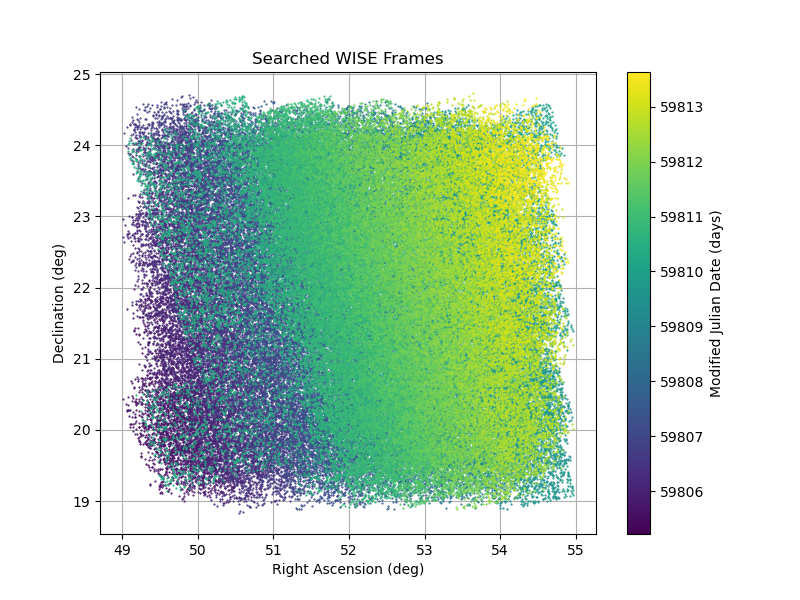

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import viridis, ScalarMappable

# Extract all MJDs from search_frames for normalization
all_mjds = np.array([frame[3] for frame in search_frames])

# Normalize MJD values to range [0, 1]
norm = Normalize(vmin=pos_mjds.min(), vmax=pos_mjds.max())
scaler = viridis  # Select the colormap

# Create the plot
plt.figure(figsize=(8, 6))

# for id in search_frames:
#     frame_num = id[0]
#     ra = id[4:12:2]
#     dec = id[5:12:2]
#     mjd = id[3]

#     color = scaler(norm(mjd))
#     plt.plot(ra + [ra[0]], dec + [dec[0]], color=color)

for i in range(len(pos_ras)):

    color = scaler(norm(pos_mjds[i]))
    plt.plot(pos_ras[i], pos_decs[i], ".", color=color, markersize=1.1)

sm = ScalarMappable(norm=norm, cmap=scaler)
sm.set_array([]) 
plt.colorbar(sm, label='Modified Julian Date (days)', ax=plt.gca())

plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.title('Searched WISE Frames')
plt.grid(True)
plt.show()


In [50]:
plt.close()

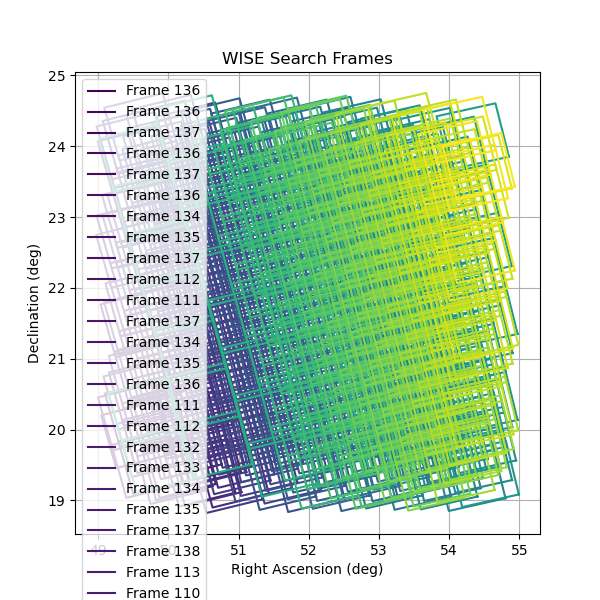

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import viridis

all_mjds = np.array([frame[3] for frame in search_frames])

norm = Normalize(vmin=all_mjds.min(), vmax=all_mjds.max())
scaler = viridis

plt.figure(figsize=(6, 6))

for id in search_frames[0:]:
    frame_num = id[0]
    ra = id[4:12:2]  # Extract RA 
    dec = id[5:12:2]  #Extract  Dec 
    mjd = id[3]

    color = scaler(norm(mjd))

    plt.plot(ra + [ra[0]], dec + [dec[0]], label=f'Frame {frame_num}', c=color)

plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.title('WISE Search Frames')
plt.grid(True)
plt.show()

(array([136., 222.,  98., 179., 120.]),
 array([59805. , 59806.6, 59808.2, 59809.8, 59811.4, 59813. ]),
 <BarContainer object of 5 artists>)

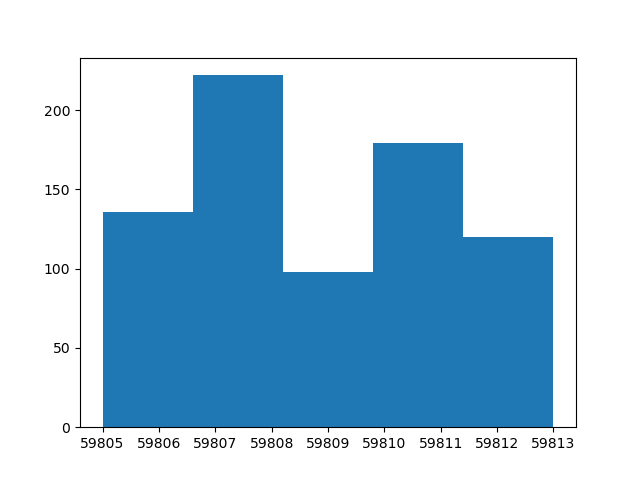

In [14]:
mjds = [int(s[3]) for s in search_frames]
plt.figure()
plt.hist(mjds, bins=5)
# plt.close()

In [4]:
def get_single_file_url(scan_id, scangrp, frame_num):

    irsa_url = "%s/%s/%03d/" % (scangrp, scan_id, frame_num)

    filename = f"{scan_id:s}{frame_num:03d}-w2-int-1b.fits"

    irsa_url = f'https://irsa.ipac.caltech.edu/ibe/data/wise/neowiser/p1bm_frm/{irsa_url}/{filename}'
    
    return irsa_url

#----------------------------------------------------------------------------------------------------------------------------

def URL_list(megalist):
    urllist = []
    for i in megalist:
        url = get_single_file_url(i[1], i[2], int(i[0]))
        urllist.append(url)
    return urllist

# urllist = URL_list(search_frames)

#----------------------------------------------------------------------------------------------------------------------------

def maskImage(path, showImage=False):
    single_path = path
    im_single = fix_byte_order(fits.getdata(single_path))

    s_bkg, s_rms = kli.background.measure_bkg_and_rms(im_single, meas_window_size=[10]*2, outlier_sigma=3, blur_sigma=20, blur_kernel_size=31, device='cpu')
    im_single_br = im_single - s_bkg # Bkg removal
    
    im_single_c = kli.nan_infill(im_single_br, s_rms)

    # im_sg_br / s_rms - > noise normalized
    
    im_coadd = kli.wise.make_wise_coadd(single_path)
    
    c_bkg, c_rms = kli.background.measure_bkg_and_rms(im_coadd, meas_window_size=[10]*2, outlier_sigma=3, blur_sigma=20, blur_kernel_size=31, device='cpu')
    im_coadd_br = im_coadd - c_bkg # Bkg removal
    
    c_obj_map = im_coadd_br > 0.5
    
    c_obj_map = binary_dilation(binary_erosion(c_obj_map, iterations=1), iterations=2)

    
    # Fill single with NaN where objects found in the coadd
    im_single_masked = im_single_c.copy()
    im_single_masked[c_obj_map] = np.nan
    
    # Measure single bkg and RMS
    
    s_bkg, s_rms = kli.background.measure_bkg_and_rms(
        im_single_masked, meas_window_size=[10]*2, outlier_sigma=3, 
        blur_sigma=20, blur_kernel_size=31, device='cpu',
    )
    # Remove single bkg
    s_b = im_single_masked - s_bkg
    # Infill single NaNs with noise
    s_i = kli.nan_infill(s_b, s_rms)

    #--------------------------------------------------------------------------------------------------------------------------------------------------------
    constant_scaler = 5

    s_norm = s_i.copy()

    low_px_mask = s_norm < -3 * s_rms

    s_norm[low_px_mask] = np.nan
    
    s_norm = kli.nan_infill(s_norm, s_rms)
    
    s_norm /= (s_rms * constant_scaler)


    #--------------------------------------------------------------------------------------------------------------------------------------------------------

    if showImage:
        axs = plot_images(
            ims=[im_single_c, s_i, im_coadd], 
            title=None, norm_same=False, fig_height=4, 
            norm_kwargs=dict(min_cut=-1, max_cut=1000), 
            imshow_kwargs=dict(cmap='viridis')
        )
        [ax.set_title(t) for ax, t in zip(axs, ['Single', 'Masked Single', 'Coadd'])];

    return s_norm, im_coadd, im_single


import numpy as np
from PIL import Image

def grid_image(image_array, square_size):
    corners = []
    # Convert the image array to a PIL image
    image = Image.fromarray(image_array)

    # Get the size of the original image
    width, height = image.size

    # Calculate the number of squares in both dimensions
    num_squares_x = width // square_size
    num_squares_y = height // square_size

    squares = []
    # Loop through the image and crop it into smaller squares
    for i in range(num_squares_x):
        for j in range(num_squares_y):
            left = i * square_size
            upper = j * square_size
            right = (i + 1) * square_size
            lower = (j + 1) * square_size

            # Crop the square
            square = image.crop((left, upper, right, lower))
            # if left == 0:
            #     print(left, upper, right, lower)
            square_array = np.array(square)
            squares.append(square_array)

            # midpt = midpoint(left, upper, right, lower)
            corners.append([left,upper])
            # print("corner: ", left, upper)

    return squares, corners

In [18]:
images = np.ones((755, 1016, 1016), dtype=np.uint8)
all_corners = []
for img in images:
    _, corners = grid_image(img, 15)
    all_corners.append(corners)
print("Processed corners for all images")
extracted_corners = [c for co in all_corners for c in co]
np.save("./AdditionalSearches/S2/S2_corners", extracted_corners)



Processed corners for all images


In [20]:
len(extracted_corners)

3389195

In [22]:
def maskImage(path, showImage=False):
    single_path = path
    im_single = fix_byte_order(fits.getdata(single_path))

    s_bkg, s_rms = kli.background.measure_bkg_and_rms(im_single, meas_window_size=[10]*2, outlier_sigma=3, blur_sigma=20, blur_kernel_size=31, device='cpu')
    im_single_br = im_single - s_bkg # Bkg removal
    
    im_single_c = kli.nan_infill(im_single_br, s_rms)

    # im_sg_br / s_rms - > noise normalized
    
    im_coadd = kli.wise.make_wise_coadd(single_path)
    
    c_bkg, c_rms = kli.background.measure_bkg_and_rms(im_coadd, meas_window_size=[10]*2, outlier_sigma=3, blur_sigma=20, blur_kernel_size=31, device='cpu')
    im_coadd_br = im_coadd - c_bkg # Bkg removal
    
    c_obj_map = im_coadd_br > 0.5
    
    c_obj_map = binary_dilation(binary_erosion(c_obj_map, iterations=1), iterations=2)

    
    im_single_masked = im_single_c.copy()
    im_single_masked[c_obj_map] = np.nan
    
    # Measure single bkg and RMS
    
    s_bkg, s_rms = kli.background.measure_bkg_and_rms(
        im_single_masked, meas_window_size=[10]*2, outlier_sigma=3, 
        blur_sigma=20, blur_kernel_size=31, device='cpu',
    )
    # Remove single bkg
    s_b = im_single_masked - s_bkg
    # Infill single NaNs with noise
    s_i = kli.nan_infill(s_b, s_rms)

    #--------------------------------------------------------------------------------------------------------------------------------------------------------

    constant_scaler = 5

    s_norm = s_i.copy()

    low_px_mask = s_norm < -3 * s_rms

    s_norm[low_px_mask] = np.nan
    
    s_norm = kli.nan_infill(s_norm, s_rms)
    
    s_norm /= (s_rms * constant_scaler)

    
    #--------------------------------------------------------------------------------------------------------------------------------------------------------

    if showImage:
        axs = plot_images(
            ims=[im_single_c, s_norm, s_i, im_coadd], 
            title=None, norm_same=False, fig_height=4, 
            # norm_kwargs=dict(min_cut=-100, max_cut=1000), 
            imshow_kwargs=dict(cmap='viridis')
        )
        [ax.set_title(t) for ax, t in zip(axs, ['Single', 'Masked Single', 'Coadd'])];

    return s_norm, im_coadd, im_single

In [8]:
# a = np.random.randn(10, 15, 15) / 5

# np.std(a)

In [129]:
# s = fits.getdata(urllist[0])
# plot_images(s)

In [8]:
len(urllist)

NameError: name 'urllist' is not defined

In [24]:
from kevlib.utils.io import mmcreate, mmload

grids = []
topcorners = []
coadds = []
bitmasks = []
singles = []

for i in tqdm(range(len(urllist))): 
    
    print("On frame " , i)
    
    m, coadd, single = maskImage(urllist[i])
    
    squares, corners = grid_image(m, square_size=15)

     # Bitmasks
    bitmask_url = urllist[i][:87] + "w2-msk-1b.fits.gz"
    bmask = fits.open(bitmask_url)
    bmask = bmask[0].data
    b_grid, _ = grid_image(bmask, 15)

    # Coadd
    c_grid, _ = grid_image(coadd, 15)

    #Single
    s_im, _ = grid_image(single, 15)
    
   
    grids.append(squares)
    coadds.append(c_grid)
    bitmasks.append(b_grid)
    topcorners.append(corners)
    singles.append(s_im)

print("finished main loop")


extracted_corners = [m for i in topcorners for m in i]

all_urls = []
for i in urllist:
    all_urls.append(i)

deploy_samples = [i for a in grids for i in a]
coadds_g = [i for a in coadds for i in a]
bitmasks_g = [i for a in bitmasks for i in a]
singles_g = [i for a in singles for i in a]

print("started creating npy files")

dep = mmcreate("./Searches/2_S1_DarkPixelsRemoved_Normalized_initial_deploy_grids.npy", dtype=float, shape=(len(deploy_samples), 15, 15), fill_value=0)
dep.flush()

coa = mmcreate("./Searches/2_S1_DarkPixelsRemoved_Normalized_coa.npy", dtype=float, shape=(len(deploy_samples), 15, 15), fill_value=0)
coa.flush()

bit = mmcreate("./Searches/2_S1_DarkPixelsRemoved_Normalized_bitmasks.npy", dtype=float, shape=(len(deploy_samples), 15, 15), fill_value=0)
bit.flush()

sng = mmcreate("./Searches/2_S1_DarkPixelsRemoved_Normalized_sng.npy", dtype=float, shape=(len(deploy_samples), 15, 15), fill_value=0)
sng.flush()

finaldep = mmcreate("./Searches/2_FinalDeploy_S1_DarkPixelsRemoved_Normalized.npy", dtype=float, shape=(len(deploy_samples), 15, 15), fill_value=0)
finaldep.flush()

print("starting to save data")

for i in range(len(dep)):
    dep[i, :, :] = deploy_samples[i]
    coa[i, :, :] = coadds_g[i]
    bit[i, :, :] = bitmasks_g[i]
    sng[i, :, :] = singles_g[i]
    
    im, c = remove_artifacts(np.array(bit[i]), dep[i])
    finaldep[i, :, :] = im
    
    dep.flush()
    coa.flush()
    bit.flush()
    sng.flush()   
    finaldep.flush()


  0%|          | 0/755 [00:00<?, ?it/s]

On frame  0
On frame  1
On frame  2
On frame  3
On frame  4
On frame  5
On frame  6
On frame  7
On frame  8
On frame  9
On frame  10
On frame  11
On frame  12
On frame  13
On frame  14
On frame  15
On frame  16
On frame  17
On frame  18
On frame  19
On frame  20
On frame  21
On frame  22
On frame  23
On frame  24
On frame  25
On frame  26
On frame  27
On frame  28
On frame  29
On frame  30
On frame  31
On frame  32
On frame  33
On frame  34
On frame  35
On frame  36
On frame  37
On frame  38
On frame  39
On frame  40
On frame  41
On frame  42
On frame  43
On frame  44
On frame  45
On frame  46
On frame  47
On frame  48
On frame  49
On frame  50
On frame  51
On frame  52
On frame  53
On frame  54
On frame  55
On frame  56
On frame  57
On frame  58
On frame  59
On frame  60
On frame  61
On frame  62
On frame  63
On frame  64
On frame  65
On frame  66
On frame  67
On frame  68
On frame  69
On frame  70
On frame  71
On frame  72
On frame  73
On frame  74
On frame  75
On frame  76
On frame 

KeyboardInterrupt: 

In [32]:
np.shape(bitmasks_g)

(3389195, 15, 15)

In [34]:
finaldep = []
for i in tqdm(range(len(deploy_samples))):

    im, c = remove_artifacts(np.array(bitmasks_g[i]), deploy_samples[i])
    finaldep.append(im)


  0%|          | 0/3389195 [00:00<?, ?it/s]

In [35]:
np.save("./Searches/2_S1_DarkPixelsRemoved_Normalized_FinalDeployGrids.npy", finaldep)

In [25]:
np.save("./Searches/2_S1_DarkPixelsRemoved_Normalized_initial_deploy_grids.npy", deploy_samples)

In [29]:
np.save("./Searches/2_S1_DarkPixelsRemoved_Normalized_coadds.npy", coadds_g)
np.save("./Searches/2_S1_DarkPixelsRemoved_Normalized_bitmasks.npy", bitmasks_g)
np.save("./Searches/2_S1_DarkPixelsRemoved_Normalized_singles.npy", singles_g)


In [32]:
len(search_frames) * 4489

3389195

In [30]:
f = np.load("./Searches/S1_DarkPixelsRemoved_Normalized_FinalDeployBitArtifactCleaned.npy")
f.shape

(3389195, 15, 15)

In [33]:
all_urls = []
for u in urllist:
    for i in range(4489):
        all_urls.append(u)

np.save("./Searches/S1_URLs", all_urls)

In [21]:
len(all_urls)

755

# Filter out bitmask patterns

In [ ]:
# finaldep = mmcreate("./Searches/Mar19_Search_DarkPixelsRemoved_Normalized_FinalDeployBitArtifactCleaned.npy", dtype=float, shape=(len(deploy_samples), 15, 15), fill_value=0)
# finaldep.flush()

# for i in tqdm(range(len(bitmasks_g))):
#     im, c = remove_artifacts(np.array(bit[i]), dep[i])
#     finaldep[i, :, :] = im


#All of this cell was incorporated into main loop cell.

In [150]:
np.save("./searchGrids", clean_bkgs)

In [31]:
# finaldep[0]

In [27]:
len(falses)

248900

In [13]:
synth = np.load("../TrainingData/104k_TrueImages_First200kof100CleanedFrames_SNR3to7.npy")

real = np.load("../TestingData/141RealDimAstImages.npy")